In [2]:
from astropy.io import fits
import os
import warnings
import numpy as np
from scipy import ndimage
from astropy import units as u
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from scipy.interpolate import interp1d
from numpy.polynomial import Polynomial
from lightkurve.lightcurve import LightCurve as LC

In [3]:
directory = '/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/'

In [4]:
directory = '/Users/arcticfox/Documents/atmospheres/v1298tau/reduced/'
files = os.listdir(directory)
files = np.sort([os.path.join(directory,fn) for fn in files if fn.endswith('m.fits.bz2')])
#files = files[11:]

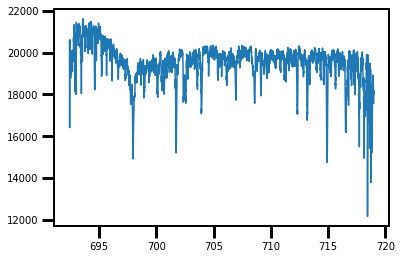

In [10]:
hdu = fits.open(files[12])
q = hdu[0].data[0]==32
plt.plot(hdu[0].data[4][q], hdu[0].data[12][q])
#plt.ylim(-1,1.01)
hdu.close()

In [9]:
from pylab import *
colormap='viridis'

cmap = cm.get_cmap(colormap, len(files))
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors)

plt.rcParams['font.size'] = 18

In [11]:
hdu1 = fits.open(files[9])
hdu2 = fits.open(files[10])
quality_pre  = np.zeros(35, dtype=np.ndarray)
quality_post = np.zeros(35, dtype=np.ndarray)

length=0
rounding = 3

for i, o in enumerate(np.unique(hdu1[0].data[0])):
    q1 = hdu1[0].data[0] == o
    q2 = hdu2[0].data[0] == o
    
    w1 = hdu1[0].data[4][q1]
    w2 = hdu2[0].data[4][q2]
    
    if w1[0] > w2[0]:
        start = np.round(w1[0],rounding)
    else:
        start = np.round(w2[0],rounding)
        
    if w1[-1] > w2[-1]:
        end = np.round(w2[-1],rounding)
    else:
        end = np.round(w1[-1],rounding)
        
    q1_new = np.where( (w1 >= start) & (w1 <= end))[0]
    q2_new = np.where( (w2 >= start) & (w2 <= end))[0]
    if len(q1_new) != len(q2_new):
        if len(q1_new)-len(q2_new) == 1:
            q1_new = q1_new[1:]
        elif len(q1_new)-len(q2_new) == -1:
            q2_new = q2_new[:-1]
        elif len(q1_new)-len(q2_new) == -2:
            q2_new = q2_new[1:-1]
            
    quality_pre[i]  = q1_new
    quality_post[i] = q2_new
        
    length += len(q1_new)
hdu1.close()
hdu2.close()

In [331]:
def sliding_kernel(w, f, window=21, percentile=99):
    steps = np.arange(0,len(f)+window,window,dtype=int)
    steps[-1] = len(f)-1
    y = np.zeros(len(steps))
    
    for i in range(len(steps)-1):
        start = int(steps[i])
        end   = int(steps[i+1])
        y[i] = np.nanpercentile(f[start:end], percentile)
        if percentile==100:
            y[i] = np.nanmax(f[start:end])
            
    y[-1] = np.nanpercentile(f[steps[-2]:], percentile)
    if percentile==100:
        y[-1] = np.nanmax(f[steps[-2]:])
    
    interp = interp1d(w[steps], y)
    return interp(w)

#######################################################

def remove_blaze(w, f, window=105, percentile=99, deg=9, which='raw'):
    y = sliding_kernel(w, f, window=window, percentile=percentile)
    
    fit = Polynomial.fit(w, y, deg=deg)
    y_smooth   = fit(w)
        
    removed = f / y 
    normalized = removed/np.nanmedian(removed)

    if which == 'raw':
        removed = f / y
        return removed/np.nanmedian(removed), removed, y
    else:
        removed = f / y_smooth
        return removed/np.nanmedian(removed), removed, y_smooth

## Alpha shape approach

In [182]:
import alphashape
from statsmodels.nonparametric.smoothers_lowess import lowess

//anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
def fit_alpha(w, f, deg=11, alpha=1.0, mask=None):
    
    if mask is not None:
        w_new = w[mask] + 0.0
        f_new = f[mask] + 0.0
    else:
        w_new = w + 0.0
        f_new = f + 0.0
        
    points = [(w_new[i], f_new[i]) for i in range(len(w_new))]
    
    alpha_shape = alphashape.alphashape(points, alpha)

    try:
        indices = [np.argmin(alpha_shape.exterior.xy[0]), 
                           np.argmax(alpha_shape.exterior.xy[0])]
        if indices[0] > indices[1]:
            indices = [indices[0], len(alpha_shape.exterior.xy[0])]
        bound_wave = alpha_shape.exterior.xy[0][indices[0]:indices[1]]
        bound_spec = alpha_shape.exterior.xy[1][indices[0]:indices[1]]
    except:
        indices = [np.argmin(alpha_shape.boundary.geoms[0].xy[0]),
                   np.argmax(alpha_shape.boundary.geoms[0].xy[0])]
        if indices[0] > indices[1]:
            indices = [indices[0], len(alpha_shape.boundary.geoms[0].xy[0])]

        bound_wave = alpha_shape.boundary.geoms[0].xy[0][indices[0]:indices[1]]
        bound_spec = alpha_shape.boundary.geoms[0].xy[1][indices[0]:indices[1]]

    fit = Polynomial.fit(bound_wave, bound_spec, deg=deg)
    y_smooth = fit(w)

    return alpha_shape, y_smooth, bound_wave, bound_spec


def alpha_plot(w, f, alpha_shape, bw, bs, y_smooth, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    #ax.scatter(w, f, c='k', s=3)
    ax.add_patch(PolygonPatch(alpha_shape, alpha=0.5))
    
    ax.plot(bw, bs, 'r', zorder=3)
    
    ax.plot(w, y_smooth, 'k', lw=2.5, zorder=3)

In [542]:
for i,fn in enumerate(files):
    newname = files[i][:-9] + '.npy'
    hdu = fits.open(fn)
    
    blaze_corr = np.array([])
    wave  = np.array([])
    order = np.array([])

    for j in range(1,len(np.unique(hdu[0].data[0]))):
        unique_order = np.unique(hdu[0].data[0])[j]
        print(i, unique_order)
        o = hdu[0].data[0] == unique_order

        w = hdu[0].data[4][o]
        f = hdu[0].data[10][o]/np.nanmedian(hdu[0].data[8][o])

        u = (np.nanmax(w) - np.nanmin(w)) / (10 * np.nanmax(f))

        f = f * u

        std1 = 3.0
        mask = np.where( (f < std1*np.std(f) + np.nanmedian(f)) &
                         (f > -std1*np.nanstd(f) + np.nanmedian(f)))[0]
        
        alpha_shape, y_smooth, bw, bs = fit_alpha(w, f, alpha=2.5, mask=mask)
        
        f_corr = f / y_smooth
        u = (np.nanmax(w) - np.nanmin(w)) / (10 * np.nanmax(f_corr))
        f_corr *= u
        
        std1 = 1.0
        mask = np.where( (f_corr > -std1*np.nanstd(f_corr) + np.nanmedian(f_corr)))[0]
        mask = np.sort(np.append(mask, [0, len(w)-1]))
        interp = interp1d(w[mask], f_corr[mask])
        
        nanmask = np.where(np.isnan(interp(w))==False)[0]
        
        line = np.ones(len(w[nanmask]))

        alpha_shape, y_smooth, bw, bs = fit_alpha(w[nanmask], interp(w)[nanmask],
                                                  alpha=0.6, deg=11)
        #alpha_plot(w[nanmask], f_corr[nanmask], alpha_shape, 
        #           bw, bs, y_smooth, ax=ax2)

        wave = np.append(wave, w[nanmask])
        
        kernel1 = sliding_kernel(w[nanmask], f_corr[nanmask])
        round1 = np.nansum( np.sqrt((line - (kernel1/np.nanmedian(kernel1)))**2) )
        kernel2 = sliding_kernel(w[nanmask], f_corr[nanmask])#/y_smooth)
        round2 = np.nansum( np.sqrt((line - (kernel2/np.nanmedian(kernel2)))**2) )

        if round1 < round2:
            blaze_corr = np.append(blaze_corr, f_corr[nanmask])
            print('1 reduction')
        else:
            blaze_corr = np.append(blaze_corr, f_corr[nanmask]/y_smooth)
            print('2 reductions')
        order = np.append(order, np.full(len(w[nanmask]), unique_order))
        
    WAVELENGTH[i] = wave
    NORMFLUX[i] = blaze_corr
    ORDERS[i] = order
    hdu.close()

0 23.0
2 reductions
0 24.0
2 reductions
0 25.0
2 reductions
0 26.0
2 reductions
0 27.0
2 reductions
0 28.0
2 reductions
0 29.0
2 reductions
0 30.0
2 reductions
0 31.0
2 reductions
0 32.0
2 reductions
0 33.0
2 reductions
0 34.0
2 reductions
0 35.0
2 reductions
0 36.0
2 reductions
0 37.0
2 reductions
0 38.0
2 reductions
0 39.0
2 reductions
0 40.0
2 reductions
0 41.0
2 reductions
0 42.0


//anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


2 reductions
0 43.0
2 reductions
0 44.0
2 reductions
0 45.0
2 reductions
0 46.0
2 reductions
0 47.0
2 reductions
0 48.0
2 reductions
0 49.0
2 reductions
0 50.0
2 reductions
0 51.0
2 reductions
0 52.0
2 reductions
0 53.0
2 reductions
0 54.0
2 reductions
0 55.0
2 reductions
0 56.0
2 reductions
1 23.0
2 reductions
1 24.0
2 reductions
1 25.0
2 reductions
1 26.0
2 reductions
1 27.0
2 reductions
1 28.0
2 reductions
1 29.0
2 reductions
1 30.0
2 reductions
1 31.0
2 reductions
1 32.0
2 reductions
1 33.0
2 reductions
1 34.0
2 reductions
1 35.0
2 reductions
1 36.0
2 reductions
1 37.0
2 reductions
1 38.0
2 reductions
1 39.0
2 reductions
1 40.0
2 reductions
1 41.0
2 reductions
1 42.0
2 reductions
1 43.0
2 reductions
1 44.0
2 reductions
1 45.0
2 reductions
1 46.0
2 reductions
1 47.0
2 reductions
1 48.0
2 reductions
1 49.0
2 reductions
1 50.0
2 reductions
1 51.0
2 reductions
1 52.0
2 reductions
1 53.0
2 reductions
1 54.0
2 reductions
1 55.0
2 reductions
1 56.0
2 reductions
2 23.0
2 reductions
2 24.0


2 reductions
12 41.0
2 reductions
12 42.0
2 reductions
12 43.0
2 reductions
12 44.0
2 reductions
12 45.0
2 reductions
12 46.0
2 reductions
12 47.0
2 reductions
12 48.0
2 reductions
12 49.0
2 reductions
12 50.0
2 reductions
12 51.0
2 reductions
12 52.0
2 reductions
12 53.0
2 reductions
12 54.0
2 reductions
12 55.0
2 reductions
12 56.0
2 reductions
13 23.0
2 reductions
13 24.0
2 reductions
13 25.0
2 reductions
13 26.0
2 reductions
13 27.0
2 reductions
13 28.0
2 reductions
13 29.0
2 reductions
13 30.0
2 reductions
13 31.0
2 reductions
13 32.0
2 reductions
13 33.0
2 reductions
13 34.0
2 reductions
13 35.0
2 reductions
13 36.0
2 reductions
13 37.0
2 reductions
13 38.0
2 reductions
13 39.0
2 reductions
13 40.0
2 reductions
13 41.0
2 reductions
13 42.0
2 reductions
13 43.0
2 reductions
13 44.0
2 reductions
13 45.0
2 reductions
13 46.0
2 reductions
13 47.0
2 reductions
13 48.0
2 reductions
13 49.0
2 reductions
13 50.0
2 reductions
13 51.0
2 reductions
13 52.0
2 reductions
13 53.0
2 reductions


24 23.0
2 reductions
24 24.0
2 reductions
24 25.0
2 reductions
24 26.0
2 reductions
24 27.0
2 reductions
24 28.0
2 reductions
24 29.0
2 reductions
24 30.0
2 reductions
24 31.0
2 reductions
24 32.0
2 reductions
24 33.0
2 reductions
24 34.0
2 reductions
24 35.0
2 reductions
24 36.0
2 reductions
24 37.0
2 reductions
24 38.0
2 reductions
24 39.0
2 reductions
24 40.0
2 reductions
24 41.0
2 reductions
24 42.0
2 reductions
24 43.0
2 reductions
24 44.0
2 reductions
24 45.0
2 reductions
24 46.0
2 reductions
24 47.0
2 reductions
24 48.0
2 reductions
24 49.0
2 reductions
24 50.0
2 reductions
24 51.0
2 reductions
24 52.0
2 reductions
24 53.0
2 reductions
24 54.0
2 reductions
24 55.0
2 reductions
24 56.0
2 reductions
25 23.0
2 reductions
25 24.0
2 reductions
25 25.0
2 reductions
25 26.0
2 reductions
25 27.0
2 reductions
25 28.0
2 reductions
25 29.0
2 reductions
25 30.0
2 reductions
25 31.0
2 reductions
25 32.0
2 reductions
25 33.0
2 reductions
25 34.0
2 reductions
25 35.0
2 reductions
25 36.0
2 red

2 reductions
35 40.0
2 reductions
35 41.0
2 reductions
35 42.0
2 reductions
35 43.0
2 reductions
35 44.0
2 reductions
35 45.0
2 reductions
35 46.0
2 reductions
35 47.0
2 reductions
35 48.0
2 reductions
35 49.0
2 reductions
35 50.0
2 reductions
35 51.0
2 reductions
35 52.0
2 reductions
35 53.0
2 reductions
35 54.0
2 reductions
35 55.0
2 reductions
35 56.0
2 reductions
36 23.0
2 reductions
36 24.0
2 reductions
36 25.0
2 reductions
36 26.0
2 reductions
36 27.0
2 reductions
36 28.0
2 reductions
36 29.0
2 reductions
36 30.0
2 reductions
36 31.0
2 reductions
36 32.0
2 reductions
36 33.0
2 reductions
36 34.0
2 reductions
36 35.0
2 reductions
36 36.0
2 reductions
36 37.0
2 reductions
36 38.0
2 reductions
36 39.0
2 reductions
36 40.0
2 reductions
36 41.0
2 reductions
36 42.0
2 reductions
36 43.0
2 reductions
36 44.0
2 reductions
36 45.0
2 reductions
36 46.0
2 reductions
36 47.0
2 reductions
36 48.0
2 reductions
36 49.0
2 reductions
36 50.0
2 reductions
36 51.0
2 reductions
36 52.0
2 reductions


2 reductions
47 23.0
2 reductions
47 24.0
2 reductions
47 25.0
2 reductions
47 26.0
2 reductions
47 27.0
2 reductions
47 28.0
2 reductions
47 29.0
2 reductions
47 30.0
2 reductions
47 31.0
2 reductions
47 32.0
2 reductions
47 33.0
2 reductions
47 34.0
2 reductions
47 35.0
2 reductions
47 36.0
2 reductions
47 37.0
2 reductions
47 38.0
2 reductions
47 39.0
2 reductions
47 40.0
2 reductions
47 41.0
2 reductions
47 42.0
2 reductions
47 43.0
2 reductions
47 44.0
2 reductions
47 45.0
2 reductions
47 46.0
2 reductions
47 47.0
2 reductions
47 48.0
2 reductions
47 49.0
2 reductions
47 50.0
2 reductions
47 51.0
2 reductions
47 52.0
2 reductions
47 53.0
2 reductions
47 54.0
2 reductions
47 55.0
2 reductions
47 56.0
2 reductions
48 23.0
2 reductions
48 24.0
2 reductions
48 25.0
2 reductions
48 26.0
2 reductions
48 27.0
2 reductions
48 28.0
2 reductions
48 29.0
2 reductions
48 30.0
2 reductions
48 31.0
2 reductions
48 32.0
2 reductions
48 33.0
2 reductions
48 34.0
2 reductions
48 35.0
2 reductions


In [545]:
NORMFLUX[1].shape, WAVELENGTH[1].shape, ORDERS[1].shape

((187631,), (187631,), (187631,))

In [534]:
for i,fn in enumerate(files):
    newname = files[i][:-9] + '.npy'
    hdu = fits.open(fn)
    
    blaze_corr = np.array([])
    wave  = np.array([])
    order = np.array([])

    for j in range(1,len(np.unique(hdu[0].data[0]))):
        unique_order = np.unique(hdu[0].data[0])[j]
        o = hdu[0].data[0] == unique_order
        
        wavemin, wavemax = hdu[0].data[4][o][0], hdu[0].data[4][o][-1]
        inds = np.where((WAVELENGTH[i] >= wavemin) & (WAVELENGTH[i] <= wavemax))[0]
        order = np.append(order, np.full(len(inds), unique_order))
    ORDERS[i] = order
    hdu.close()

In [498]:
np.save('alpha_wave.npy', WAVELENGTH)

In [499]:
np.save('alpha_spec.npy', NORMFLUX)

In [500]:
np.save('alpha_orders.npy', ORDERS)

In [540]:
ORDERS[j].shape, WAVELENGTH[j].shape

((258400,), (187631,))

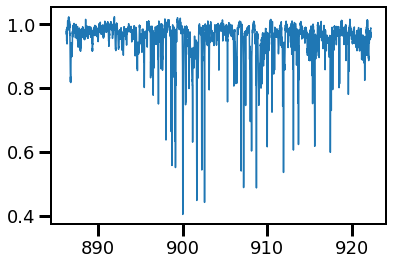

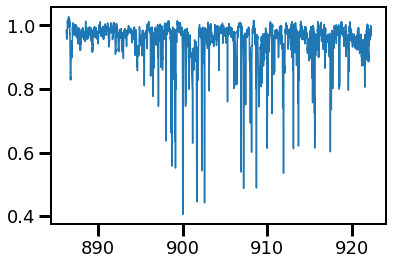

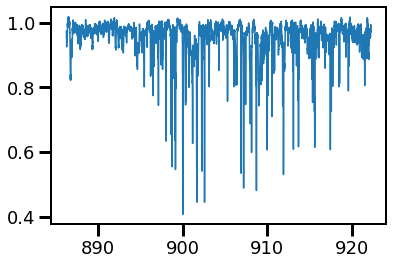

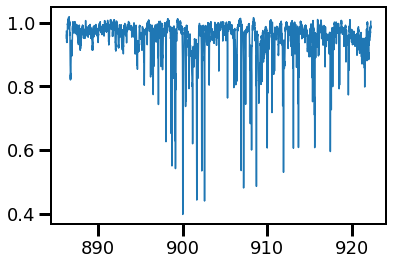

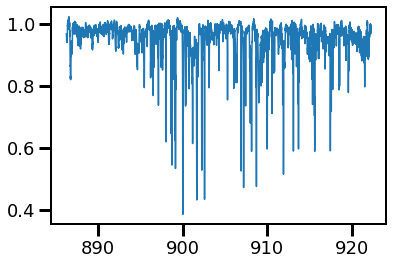

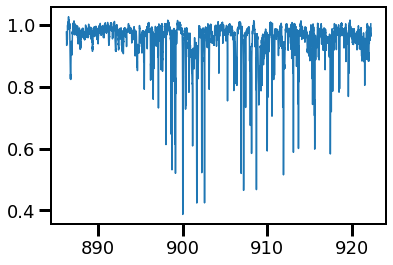

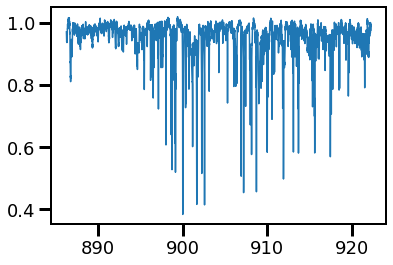

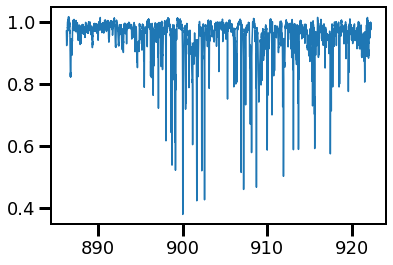

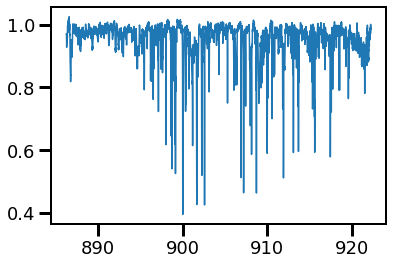

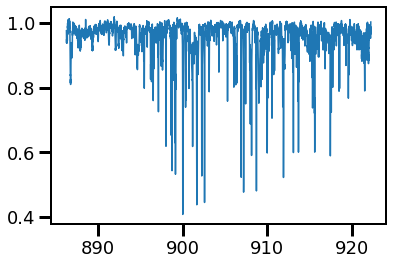

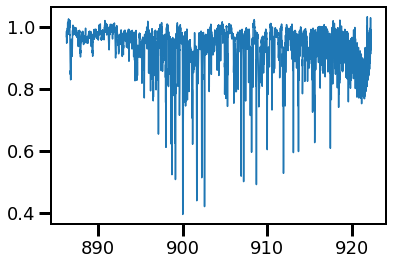

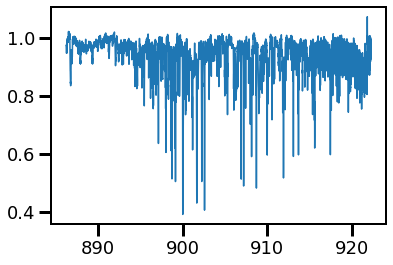

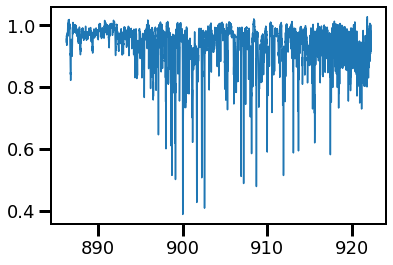

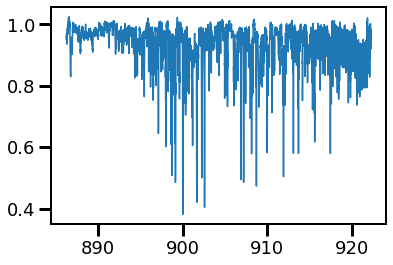

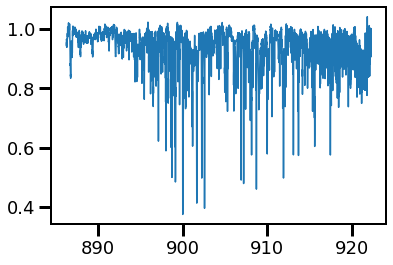

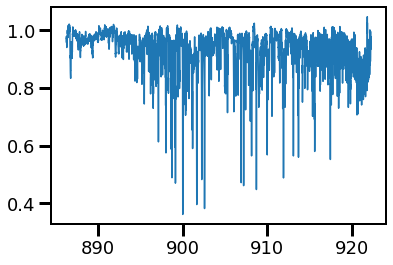

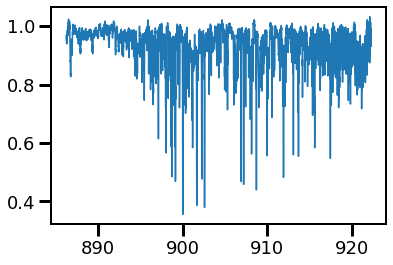

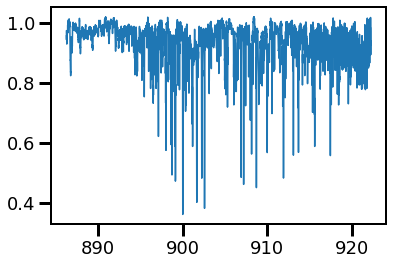

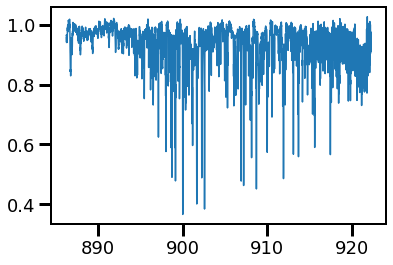

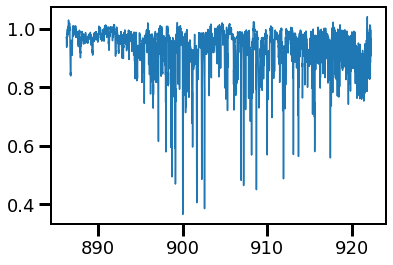

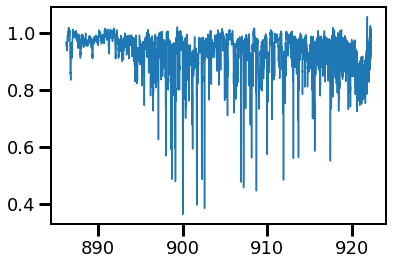

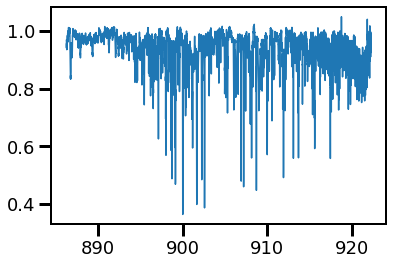

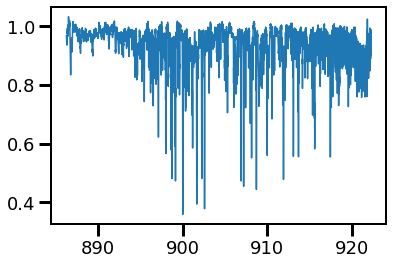

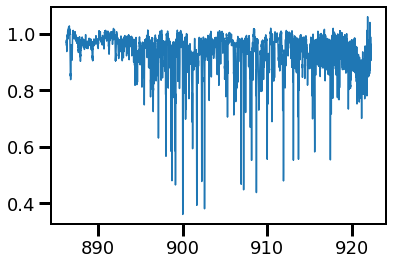

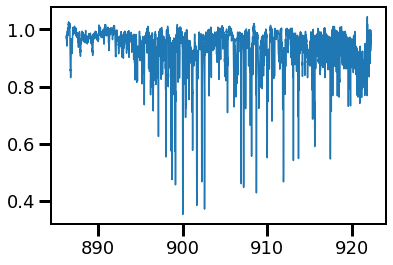

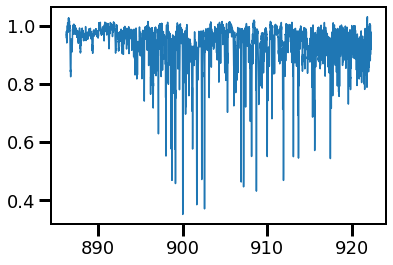

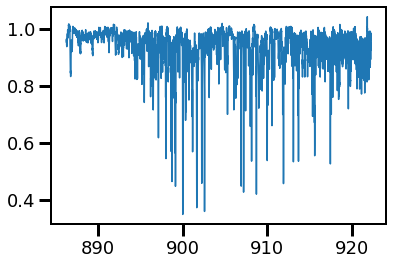

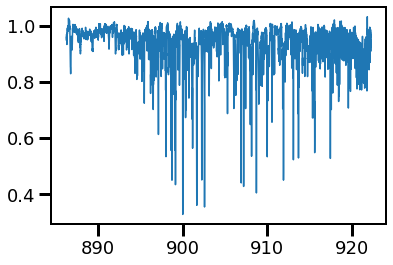

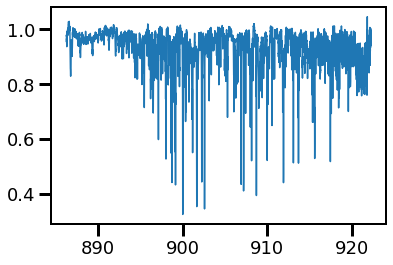

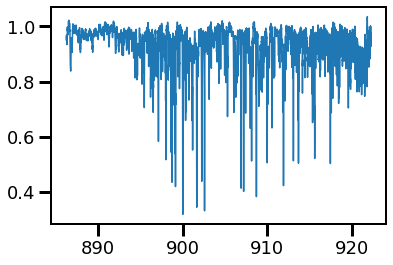

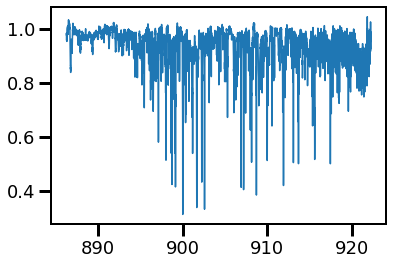

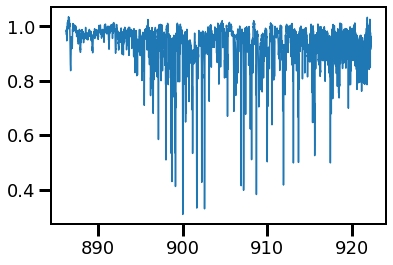

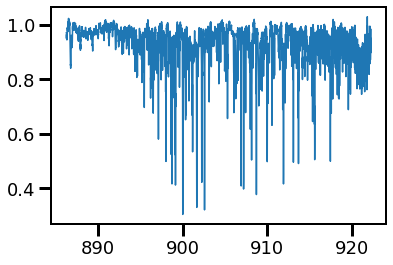

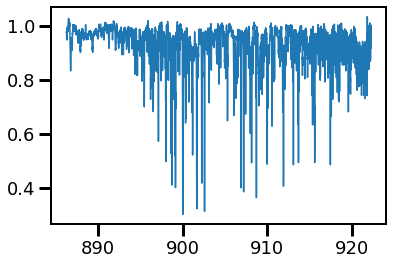

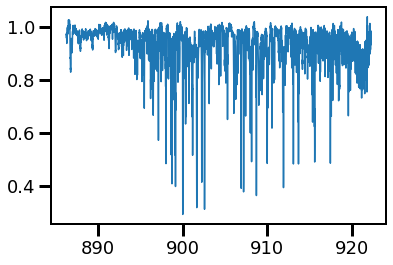

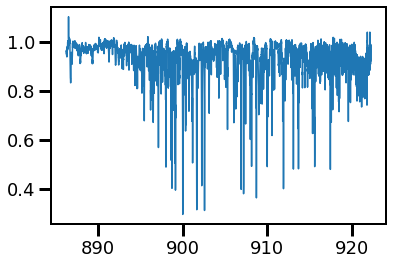

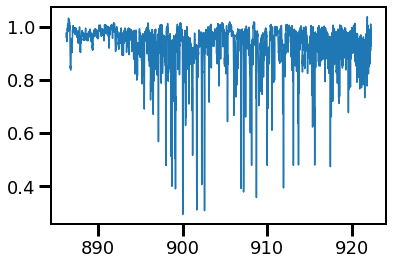

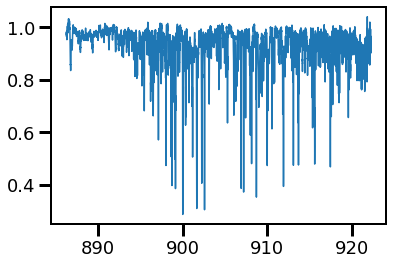

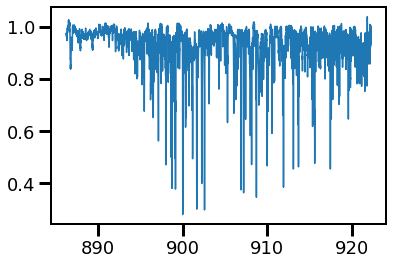

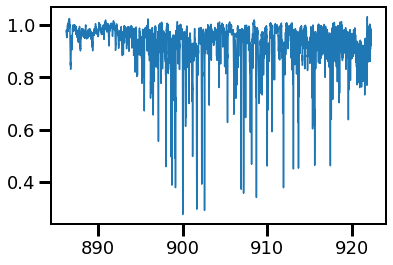

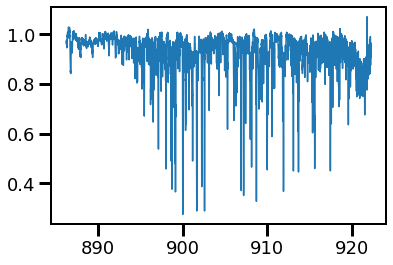

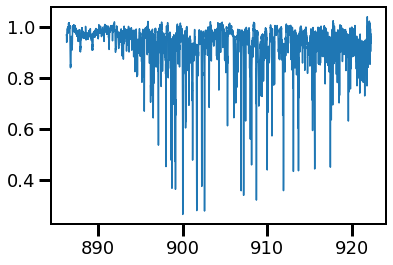

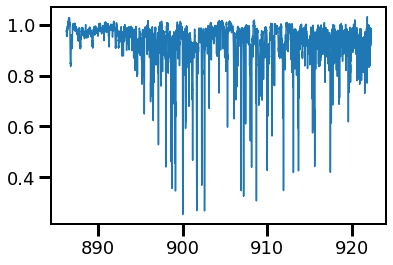

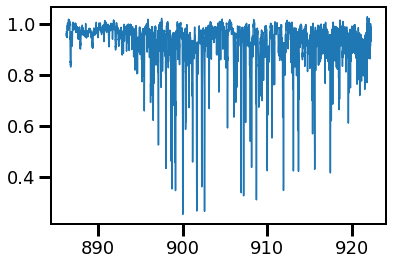

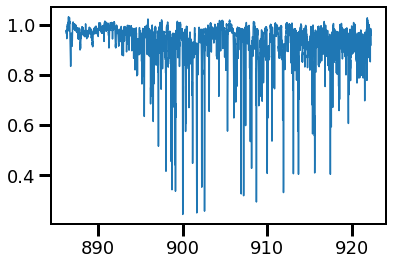

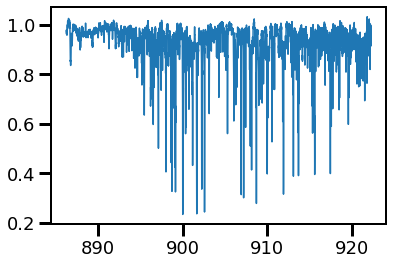

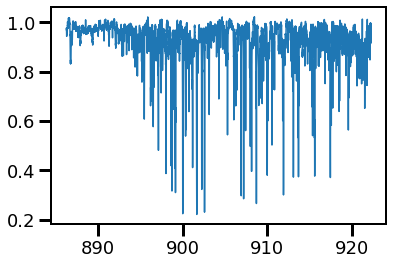

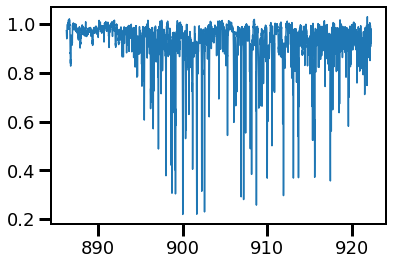

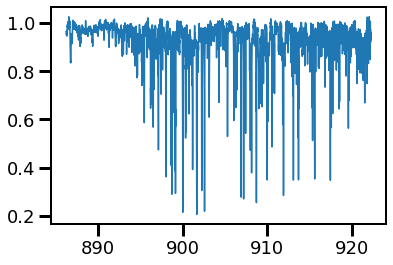

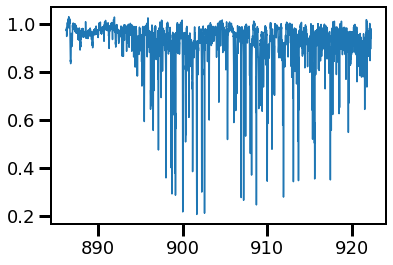

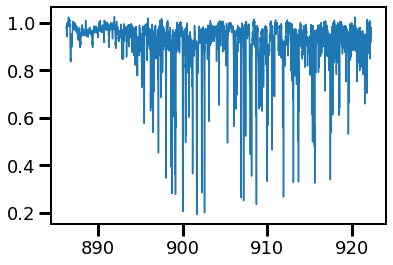

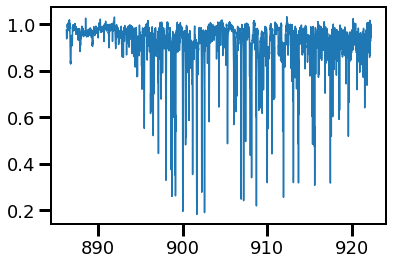

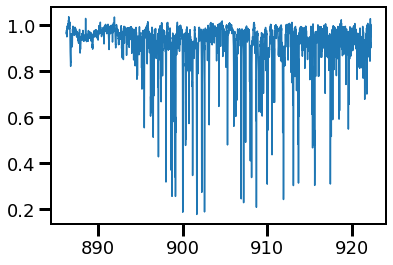

In [548]:
for j in range(len(WAVELENGTH)):
    o = ORDERS[j] == 25
    plt.plot(WAVELENGTH[j][o], NORMFLUX[j][o])#/np.nanmedian(NORMFLUX[j]))
    plt.show()

In [549]:
def grid_wavelength(wavelength, spectra, order, length):
    per_order = int(length/len(np.unique(order)))
    
    interp_waves = np.zeros((len(np.unique(order)), per_order))
    interp_spect = np.zeros((len(np.unique(order)), per_order))
    interp_order = np.zeros((len(np.unique(order)), per_order))
    
    for i, uo in enumerate(np.unique(order)):
        w, f = wavelength[order==uo], spectra[order==uo]

        redstart = w[0]
        blueend = w[-1]

        finer_wavelength = np.logspace(np.log10(redstart), np.log10(blueend),
                                       per_order, base=10.0)
        finer_wavelength[0] = redstart
        finer_wavelength[-1] = blueend
        
        f = interp1d(w, f)
        interp_spect[i] = f(finer_wavelength)
        interp_waves[i] = finer_wavelength
        interp_order[i] = np.full(per_order, uo)
    
    interp_waves = np.reshape(interp_waves, per_order*len(np.unique(order)))
    interp_spect = np.reshape(interp_spect, per_order*len(np.unique(order)))
    interp_order = np.reshape(interp_order, per_order*len(np.unique(order)))

    return interp_waves, interp_spect, interp_order

In [553]:
FACTOR = 3
length = 1688916

INTERPOLATED_WAVELENGTH = np.zeros( (len(WAVELENGTH), length) )
INTERPOLATED_SPECTRA    = np.zeros( (len(WAVELENGTH), length) )
INTERPOLATED_ORDERS     = np.zeros( (len(WAVELENGTH), length) )

for i in range(len(WAVELENGTH)):
    iw, iss, io = grid_wavelength(WAVELENGTH[i], NORMFLUX[i], ORDERS[i], 562972*FACTOR)
    INTERPOLATED_WAVELENGTH[i] = iw
    INTERPOLATED_SPECTRA[i] = iss
    INTERPOLATED_ORDERS[i]  = io

In [554]:
np.save('interpolized_wave_fresh.npy', INTERPOLATED_WAVELENGTH)
np.save('interpolized_spec_fresh.npy', INTERPOLATED_SPECTRA)
np.save('interpolized_order_fresh.npy', INTERPOLATED_ORDERS)

In [223]:
from astropy.time import Time
dates = Time(DATES, format='mjd').jd
dates

array([2458870.778, 2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  ,
       2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  ,
       2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  ,
       2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  ,
       2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  ,
       2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  ,
       2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  ,
       2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  ,
       2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  ,
       2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  , 2400000.5  ,
       2400000.5  , 2400000.5  , 2400000.5  ])

In [224]:
WAVELENGTH.shape

(53,)

In [213]:
OUT = np.where( dates>2458870.941)[0]
BOTH = np.where(dates<=2458870.762)[0]
BOTH

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [214]:
np.save('1d_wavelength.npy', WAVELENGTH)
np.save('1d_spectra.npy', NORMFLUX)
np.save('1d_orders.npy', ORDERS)

## Checking spectra

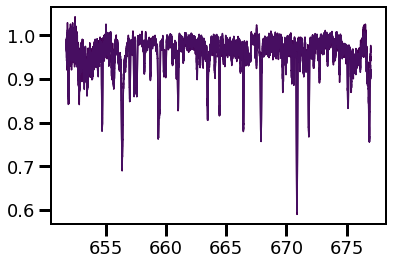

In [231]:
order = 34
fig, ax = plt.subplots()
for i in range(3):
    plt.plot(WAVELENGTH[i][ORDERS[i]==order],
            NORMFLUX[i][ORDERS[i]==order], c=colors[i])
ax.set_facecolor('w')
plt.show()

## Getting the interpolation start & end points

In [216]:
start_end = np.zeros((len(np.unique(ORDERS[0])), 2))

for o in range(len(np.unique(ORDERS[0]))):
    temp_start = np.zeros(len(WAVELENGTH))
    temp_stop  = np.zeros(len(WAVELENGTH))
    order = np.unique(ORDERS[0])[o]
    
    for i in range(len(WAVELENGTH)):
        q = ORDERS[i] == int(order)
        temp_start[i] = WAVELENGTH[i][q][0]
        temp_stop[i]  = WAVELENGTH[i][q][-1]
        
    start_end[o][0] = np.nanmax(temp_start)
    start_end[o][1] = np.nanmin(temp_stop)

## Interpolating Wavelengths

In [217]:
def grid_wavelength(wavelength, spectra, orders, factor):
    global WAVELENGTH, ORDERS
#    interp_waves = np.zeros(len(wavelength))#, wavelength.shape[1]*factor))
#    interp_spect = np.zeros(len(spectra))#, spectra.shape[1]*factor))   

    unique_orders = np.unique(orders)
    interp_waves = np.array([])
    interp_spect = np.array([])
    interp_orders = np.array([])
    
    for i, o in enumerate(unique_orders):
        q = orders == o
        redstart = start_end[i][0]
        blueend = start_end[i][1]

        qtemp = ORDERS[0] == o
        finer_wavelength = np.logspace(log10(redstart), log10(blueend),
                                       len(WAVELENGTH[0][qtemp])*factor, base=10.0)

        finer_wavelength[0]=redstart
        finer_wavelength[-1]=blueend
        
        f = interp1d(wavelength[q], spectra[q])
        interp_spect = np.append(interp_spect, f(finer_wavelength))
        interp_waves = np.append(interp_waves, finer_wavelength)
        interp_orders = np.append(interp_orders, np.full(len(finer_wavelength), o))
    
    return interp_waves, interp_spect, interp_orders

In [218]:
FACTOR = 3

INTERPOLATED_WAVELENGTH = np.zeros( (len(WAVELENGTH), 582945) )
INTERPOLATED_SPECTRA    = np.zeros( (len(WAVELENGTH), 582945) )
INTERPOLATED_ORDERS     = np.zeros( (len(WAVELENGTH), 582945) )

for i in range(len(WAVELENGTH)):
    iw, iss, io = grid_wavelength(WAVELENGTH[i], NORMFLUX[i], ORDERS[i], FACTOR)
    INTERPOLATED_WAVELENGTH[i] = iw
    INTERPOLATED_SPECTRA[i] = iss
    INTERPOLATED_ORDERS[i] = io

(0.8, 1.1)

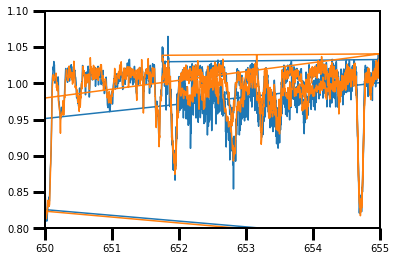

In [219]:
plt.plot(INTERPOLATED_WAVELENGTH[0], INTERPOLATED_SPECTRA[0])
plt.plot(INTERPOLATED_WAVELENGTH[15], INTERPOLATED_SPECTRA[15])
plt.xlim(650,655)
plt.ylim(0.8,1.1)

## Stellar RV

In [220]:
star_bc = 16.15 * u.km / u.s
speedlight = 2.998e8 * u.m / u.s
dopshift = ((INTERPOLATED_WAVELENGTH*u.nm * star_bc) / speedlight).to(u.nm)
INTERPOLATED_WAVELENGTH = (INTERPOLATED_WAVELENGTH*u.nm - dopshift).to(u.nm).value

In [221]:
INTERPOLATED_ORDERS.shape

(53, 582945)

In [222]:
np.save('interp_1d_wavelength.npy', INTERPOLATED_WAVELENGTH)
np.save('interp_1d_spectra.npy', INTERPOLATED_SPECTRA)
np.save('interp_1d_orders.npy', INTERPOLATED_ORDERS)

In [223]:
np.where(WAVELENGTH[0]>=514.8838)[0][-1]

140257

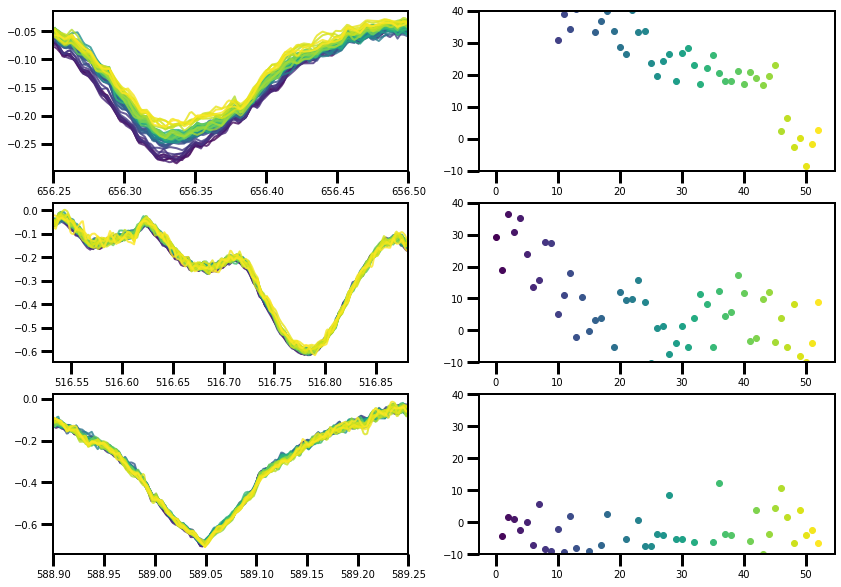

In [224]:
fig, ((ax1,ax2), (ax3,ax4), (ax5,ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(14,10))
new_feature=[656.35, 516.7322, 589.1]
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

feature = 0
for count in [0,2,4]:
    ax1 = axes[count]
    ax2 = axes[count+1]
    for i in range(len(INTERPOLATED_ORDERS)):
        if count == 0:
            order = 34
            bounds = [0.1,0.15]
           #ax1.set_ylim(-0.3,0)
        else:
            lim = np.where(INTERPOLATED_WAVELENGTH[i] >= new_feature[feature])[0][-1]
            order = int(INTERPOLATED_ORDERS[i][lim])
            bounds = [0.2, 0.15]
        
        q = ((INTERPOLATED_ORDERS[i] == order) & 
             (INTERPOLATED_WAVELENGTH[i] >= new_feature[feature]-bounds[0]) & 
             (INTERPOLATED_WAVELENGTH[i] <= new_feature[feature]+bounds[1]))

        flux = INTERPOLATED_SPECTRA[i][q] - 1
        wave = INTERPOLATED_WAVELENGTH[i][q]
        template = np.nanmedian(INTERPOLATED_SPECTRA[OUT], axis=0)[q] - 1
        
        ax1.plot(wave, flux, alpha=0.8, c=colors[i], lw=2)

        ax1.set_xlim(new_feature[feature]-bounds[0],new_feature[feature]+bounds[1])
        
        try:
            ax2.plot(i, np.nansum( (flux[1:]/template) - 1 ) , 'o',c=colors[i])
        except:
            ax2.plot(i, np.nansum( (flux/template) - 1 ) , 'o',c=colors[i])
#        print(np.nansum( (flux/template) - 1 ))
        ax2.set_ylim(-10,40)
    feature += 1
#ax1.set_xlabel('Wavelength [nm]')
#ax2.set_xlabel('Wavelength [nm]')
#ax1.set_ylabel('Normalized Flux')
#ax2.set_title('Sodium')
#plt.savefig('/Users/arcticfox/Desktop/hooray.png', dpi=250, rasterize=True,
#           bbox_inches='tight')

In [225]:
np.save('1d_orders.npy', ORDERS)
np.save('1d_wavelength.npy', WAVELENGTH)
np.save('1d_spectra.npy', NORMFLUX)
np.save('mjddates.npy', DATES)

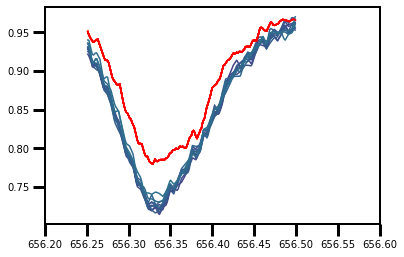

In [226]:
#plt.plot(np.arange(0,1000,10), np.arange(0,1000,10), 'r')
order = 34
bounds = [0.1,0.15]

for i in range(len(BOTH)+1):
    
    q = ((INTERPOLATED_ORDERS[i] == order) & 
         (INTERPOLATED_WAVELENGTH[i] >= 656.35-bounds[0]) & 
         (INTERPOLATED_WAVELENGTH[i] <= 656.35+bounds[1]))
    template_s = np.nanmedian(INTERPOLATED_SPECTRA[OUT], axis=0)[q]
    template_w = np.nanmedian(INTERPOLATED_WAVELENGTH[OUT], axis=0)[q]
    plt.plot(template_w, template_s, 'r')
    plt.plot(INTERPOLATED_WAVELENGTH[i][q], INTERPOLATED_SPECTRA[i][q], c=colors[i+10])

plt.xlim(656.2, 656.6)
#plt.ylim(656.2, 656.5)
plt.show()